## 4. Aprendizaje no supervisado con redes neuronales 

Tras el resurgimiento de las redes neuronales se han producido múltiples avances en el área de aprendizaje no supervisado. Una de las aplicaciones principales en este sentido son los autoencoders. La intuición tras un autoencoder clásico es **aprender una representación más compacta de la entrada** tratando de reconstruirla en su salida.

Un autoencoder consiste en una red neuronal monocapa donde el número de neuronas en la salida coincide con el número de neuronas de entrada, mientras que la capa oculta dispone de menos neuronas. Tras entrenar una red de este tipo se puede utilizar la salida para, por ejemplo, [eliminar ruido](https://www.doc.ic.ac.uk/~js4416/163/website/autoencoders/denoising.html), pero su capa intermedia también atrae interés porque es una representación "compacta" de la entrada que ha aprendido a extraer su información esencial para maximizar el éxito en la reconstrucción. 

<div style="float:left; margin: 20px;">
<img src="http://ufldl.stanford.edu/tutorial/images/Autoencoder636.png" alt="Esquema de Autoencoder" style="height: 400px;"/>
<p style="margin: 0; text-align:center;">Fig. 1. Esquema de autoencoder</p>
</div>
<div style="margin: 20px;">
<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" alt="Ejemplo Autoencoder" style="height: 150px;"/>
<p style="margin: 0; text-align:center;">Fig. 2. Ejemplo de autoencoder</p>
</div>

Tal y como se puede observar en la figura 2, la capa o capas que llevan hasta la representación compacta se llaman *Encoder*, y la parte que va desde la representación compacta hasta la salida se denomina *Decoder*.

En este ejercicio utilizaremos un autoencoder con 2 neuronas en la capa intermedia para obtener una representación en dos dimensiones de las series temporales correspondientes al precio de diferentes criptomonedas. Esto nos permitirá mostrar la representación compacta de las criptomonedas en un plano y clusterizar visualmente aquellas criptomonedas que hayan tenido un comportamiento similar a lo largo del tiempo.

El siguiente código descarga la información de las criptomonedas. Concretamente, utilizamos la [*API* de cryptocompare](https://www.cryptocompare.com/api/) para descargar el precio de cierre de cada día durante el último año de 100 criptomonedas..

In [2]:
import json
import requests

N_DAYS = 365
N_COINS = 100

# Get coin list.
#
response = requests.get('https://www.cryptocompare.com/api/data/coinlist/')
coins = [k for k, v in json.loads(response.text)['Data'].items() if int(v['SortOrder']) <= N_COINS]

# Get daily @ close for each coin.
series = {}
for coin in coins:
    try:
        response = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym=USD&limit={}&e=CCCAGG'.format(coin, N_DAYS - 1))
        data = json.loads(response.text)['Data']
        if (len(data) == N_DAYS and all(t < 100000 for t in [d['close'] for d in data])):
            series[coin] = [x['close'] for x in data]
            print(coin, end=' ')
        else:
            print('*{}*'.format(coin), end=' ')
    except:
        print('*{}*'.format(coin), end=' ')

DOGE ZEC BTS DGB BTCD CRAIG XPY PRC YBC DANK GIVE KOBO DT CETI SUP XPD GEO CHASH SPR NXTI WOLF XDP 2015 *42* AC ALF AGS AMC ALN ARI AUR AXR BCX BEN BITB BLU BLK BOST BQC XMY MOON ZET ENRG QRK RIC DGC CAIX BTG* BUK CACH CANN CAP CASH CCN CINNI CLAM CLOAK CLR CMC CNC CNL COMM COOL CRACK *CRC** CRYPT DEM ARG BTM PPC ACOIN AERO APEX ARCH BET QTL LIMX BTB BTE CIN CXC DRKC XBS DMD CAT1 XVG SXC CSC XRP LTC DASH CBX ETC ETH NXT XMR BTC 

Con el siguiente código podemos ver la información descargada para cada moneda en un único gráfico.

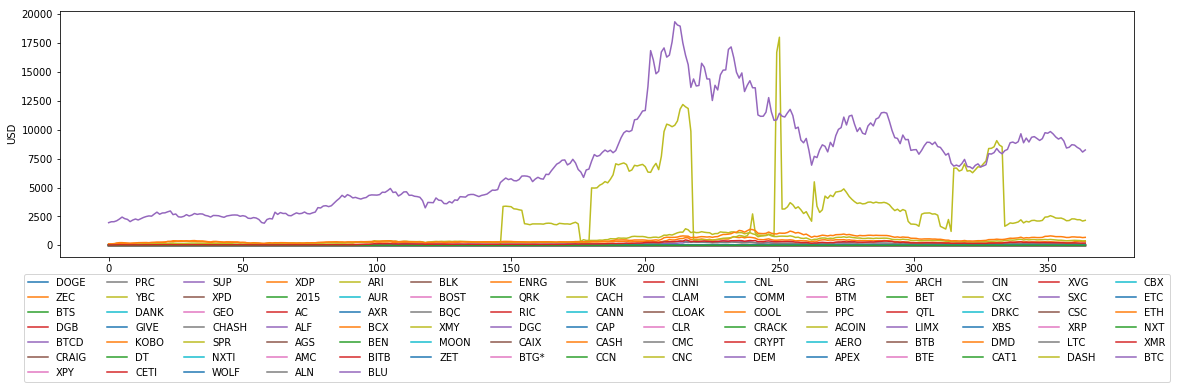

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for k, v in series.items():
    ax.plot(range(len(v)), v, label=k)
    ax.set_ylabel('USD')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=15)
plt.tight_layout()

En la gráfica anterior se observa como pocas monedas (como BTC, Bitcoin) tienen valores muy altos en USD (miles de dólares), pero la mayoría tienen poco valor (típicamente centavos). Para encontrar similitudes entre series con independencia de su escala (y para facilitar el entrenamiento del autoencoder) es buena idea normalizar las series.

Con el siguiente código primero normalizamos las series dividiendo cada valor por el máximo de la serie y volvemos a mostrar la gráfica.

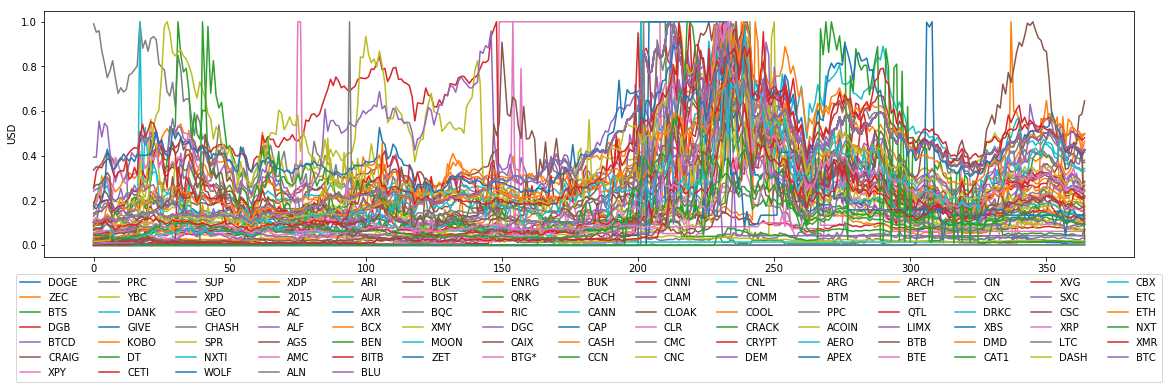

In [4]:
import numpy as np

series_norm = {k: np.array(v) / max(v) for k, v in series.items()}

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for k, v in series_norm.items():
    ax.plot(range(len(v)), v, label=k)
    ax.set_ylabel('USD')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=15)
plt.tight_layout()

In [5]:
# Analizar, limpiar y preparar los datos de las series de entrada


# convertir el diccionario series_norm, en una matriz de filas(num. cryptomonedas) x 
# columnas (precio diario). Es el argumento que necesita fit()

cryto_values=np.array(list(series_norm.values()))
print(cryto_values.shape) #dimensión de la matriz
print(cryto_values)
print()

# Crear array con las etiquetas de las crytomonedas
crypto_labels=np.array(list(series_norm.keys()))
print(crypto_labels)
print()

# Podemos acceder a la cotizacion de una crypto (x) por dia (y)
print(crypto_labels[0],cryto_values[0,0]) # cotización de DODGE el día 1
print(crypto_labels[0],cryto_values[0,364]) #cotización de DODGE el día 365
print(crypto_labels[93],cryto_values[93,364]) 
print()

# Comprobar que los valores están dentro de los rangos aceptados por el modelo (0,1)
print(" Máximo valor de la matriz:",np.max(cryto_values))
print(" Mínimo valor de la matriz:",np.min(cryto_values))


(95, 365)
[[ 0.08464706  0.103       0.16929412 ...,  0.25770588  0.24558824
   0.25023529]
 [ 0.13711584  0.13847617  0.15629251 ...,  0.48349776  0.41484739
   0.46591915]
 [ 0.08582588  0.09463376  0.11046077 ...,  0.2825767   0.27612363
   0.2864259 ]
 ..., 
 [ 0.04187719  0.04385965  0.04559064 ...,  0.09678363  0.09152047
   0.0928655 ]
 [ 0.0684492   0.0744385   0.0735615  ...,  0.42530481  0.40851337
   0.4286631 ]
 [ 0.10141899  0.10546024  0.10566752 ...,  0.43135532  0.41720525
   0.42660124]]

['DOGE' 'ZEC' 'BTS' 'DGB' 'BTCD' 'CRAIG' 'XPY' 'PRC' 'YBC' 'DANK' 'GIVE'
 'KOBO' 'DT' 'CETI' 'SUP' 'XPD' 'GEO' 'CHASH' 'SPR' 'NXTI' 'WOLF' 'XDP'
 '2015' 'AC' 'ALF' 'AGS' 'AMC' 'ALN' 'ARI' 'AUR' 'AXR' 'BCX' 'BEN' 'BITB'
 'BLU' 'BLK' 'BOST' 'BQC' 'XMY' 'MOON' 'ZET' 'ENRG' 'QRK' 'RIC' 'DGC'
 'CAIX' 'BTG*' 'BUK' 'CACH' 'CANN' 'CAP' 'CASH' 'CCN' 'CINNI' 'CLAM'
 'CLOAK' 'CLR' 'CMC' 'CNC' 'CNL' 'COMM' 'COOL' 'CRACK' 'CRYPT' 'DEM' 'ARG'
 'BTM' 'PPC' 'ACOIN' 'AERO' 'APEX' 'ARCH' 'BET' 'QTL' 'L

A continuación crearemos el autoencoder utilizando una capa de entrada con tantas neuronas como días tenemos de información, una capa intermedia con dos neuronas para facilitar la visualización de los datos comprimidos y una capa de salida con el mismo número de neuronas que la capa de entrada. Para este ejercicio utilizaremos neuronas con la tangente hiperbólica como función de activación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Construir y entrenar el autoencoder teniendo en cuenta que en el siguiente ejercicio necesitaremos poder acceder a los resultados de la capa intermedia. Podéis utilizar los módulos Model, Input y Dense de Keras.
</div>

In [12]:
from keras.models import Model
from keras.layers import Input,Dense


# Datos de los 365 dias por cada cryptomoneda para capa de entrada
input_data = Input(shape=(365,))
    
# "encoded" is the encoded representation of the input
encoded = Dense(2 , activation='tanh')(input_data)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(365, activation='tanh')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# Compilar  modelo , usando función loss más sensible a outliers (media error absoluto)
autoencoder.compile(optimizer='Adam',loss='mean_absolute_error',metrics=['accuracy'])

print (autoencoder.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 732       
_________________________________________________________________
dense_8 (Dense)              (None, 365)               1095      
Total params: 1,827
Trainable params: 1,827
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# Entrenar autoencoder
Auto_Encoder=autoencoder.fit(cryto_values,cryto_values,batch_size=100,nb_epoch=1000,verbose=1)


Epoch 1/1000
95/95 [==============================] - 0s - loss: 0.2600 - acc: 0.0211
Epoch 2/1000
95/95 [==============================] - 0s - loss: 0.2583 - acc: 0.0105
Epoch 3/1000
95/95 [==============================] - 0s - loss: 0.2567 - acc: 0.0211
Epoch 4/1000
95/95 [==============================] - 0s - loss: 0.2550 - acc: 0.0105
Epoch 5/1000
95/95 [==============================] - 0s - loss: 0.2533 - acc: 0.0000e+00
Epoch 6/1000
95/95 [==============================] - 0s - loss: 0.2515 - acc: 0.0000e+00
Epoch 7/1000
95/95 [==============================] - 0s - loss: 0.2497 - acc: 0.0000e+00
Epoch 8/1000
95/95 [==============================] - 0s - loss: 0.2479 - acc: 0.0000e+00
Epoch 9/1000
95/95 [==============================] - 0s - loss: 0.2461 - acc: 0.0000e+00
Epoch 10/1000
95/95 [==============================] - 0s - loss: 0.2443 - acc: 0.0000e+00
Epoch 11/1000
95/95 [==============================] - 0s - loss: 0.2424 - acc: 0.0000e+00
Epoch 12/1000
95/95 [===

95/95 [==============================] - 0s - loss: 0.0909 - acc: 0.0105
Epoch 186/1000
95/95 [==============================] - 0s - loss: 0.0906 - acc: 0.0105
Epoch 187/1000
95/95 [==============================] - 0s - loss: 0.0903 - acc: 0.0105
Epoch 188/1000
95/95 [==============================] - 0s - loss: 0.0900 - acc: 0.0105
Epoch 189/1000
95/95 [==============================] - 0s - loss: 0.0896 - acc: 0.0105
Epoch 190/1000
95/95 [==============================] - 0s - loss: 0.0893 - acc: 0.0105
Epoch 191/1000
95/95 [==============================] - 0s - loss: 0.0890 - acc: 0.0105
Epoch 192/1000
95/95 [==============================] - 0s - loss: 0.0887 - acc: 0.0105
Epoch 193/1000
95/95 [==============================] - 0s - loss: 0.0884 - acc: 0.0105
Epoch 194/1000
95/95 [==============================] - 0s - loss: 0.0881 - acc: 0.0105
Epoch 195/1000
95/95 [==============================] - 0s - loss: 0.0878 - acc: 0.0105
Epoch 196/1000
95/95 [=========================

95/95 [==============================] - 0s - loss: 0.0607 - acc: 0.0316
Epoch 372/1000
95/95 [==============================] - 0s - loss: 0.0607 - acc: 0.0316
Epoch 373/1000
95/95 [==============================] - 0s - loss: 0.0606 - acc: 0.0316
Epoch 374/1000
95/95 [==============================] - 0s - loss: 0.0605 - acc: 0.0316
Epoch 375/1000
95/95 [==============================] - 0s - loss: 0.0605 - acc: 0.0316
Epoch 376/1000
95/95 [==============================] - 0s - loss: 0.0604 - acc: 0.0316
Epoch 377/1000
95/95 [==============================] - 0s - loss: 0.0603 - acc: 0.0316
Epoch 378/1000
95/95 [==============================] - 0s - loss: 0.0603 - acc: 0.0316
Epoch 379/1000
95/95 [==============================] - 0s - loss: 0.0602 - acc: 0.0316
Epoch 380/1000
95/95 [==============================] - 0s - loss: 0.0601 - acc: 0.0316
Epoch 381/1000
95/95 [==============================] - 0s - loss: 0.0601 - acc: 0.0316
Epoch 382/1000
95/95 [=========================

95/95 [==============================] - 0s - loss: 0.0536 - acc: 0.0842
Epoch 558/1000
95/95 [==============================] - 0s - loss: 0.0536 - acc: 0.0842
Epoch 559/1000
95/95 [==============================] - 0s - loss: 0.0535 - acc: 0.0842
Epoch 560/1000
95/95 [==============================] - 0s - loss: 0.0535 - acc: 0.0842
Epoch 561/1000
95/95 [==============================] - 0s - loss: 0.0535 - acc: 0.0842
Epoch 562/1000
95/95 [==============================] - 0s - loss: 0.0535 - acc: 0.0842
Epoch 563/1000
95/95 [==============================] - 0s - loss: 0.0534 - acc: 0.0842
Epoch 564/1000
95/95 [==============================] - 0s - loss: 0.0534 - acc: 0.0842
Epoch 565/1000
95/95 [==============================] - 0s - loss: 0.0534 - acc: 0.0737
Epoch 566/1000
95/95 [==============================] - 0s - loss: 0.0534 - acc: 0.0737
Epoch 567/1000
95/95 [==============================] - 0s - loss: 0.0534 - acc: 0.0737
Epoch 568/1000
95/95 [=========================

95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0737
Epoch 744/1000
95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0737
Epoch 745/1000
95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0842
Epoch 746/1000
95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0737
Epoch 747/1000
95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0842
Epoch 748/1000
95/95 [==============================] - 0s - loss: 0.0512 - acc: 0.0737
Epoch 749/1000
95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0737
Epoch 750/1000
95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0842
Epoch 751/1000
95/95 [==============================] - 0s - loss: 0.0512 - acc: 0.0737
Epoch 752/1000
95/95 [==============================] - 0s - loss: 0.0512 - acc: 0.0737
Epoch 753/1000
95/95 [==============================] - 0s - loss: 0.0513 - acc: 0.0842
Epoch 754/1000
95/95 [=========================

95/95 [==============================] - 0s - loss: 0.0505 - acc: 0.0737
Epoch 930/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 931/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 932/1000
95/95 [==============================] - 0s - loss: 0.0505 - acc: 0.0737
Epoch 933/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 934/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 935/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 936/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 937/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 938/1000
95/95 [==============================] - 0s - loss: 0.0505 - acc: 0.0737
Epoch 939/1000
95/95 [==============================] - 0s - loss: 0.0504 - acc: 0.0737
Epoch 940/1000
95/95 [=========================

Vemos que el valor de loss se va minimizando en cada iteración de los epochs, con lo que el entrenamiento es coherente con los parámetros usados en el modelo y en el caso del ejercicio la predicción del encoder deberá compactar las series bien. Hemos probado con diferentes valores de epochs (hasta 1000 para la gráfica) donde se ve que lentamente converge hacía 0.

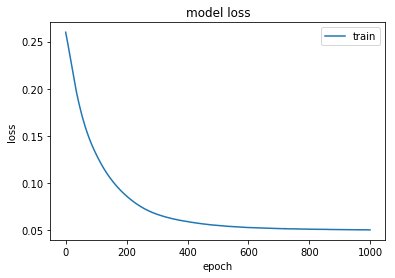

In [8]:
# loss
plt.plot(Auto_Encoder.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='best')
plt.show()



Para obtener la representación compacta de las series temporales es necesario invocar al método [predict](https://keras.io/models/model/#predict) del encoder y alimentarlo con cada serie temporal normalizada.

El *embedding* (salida del encoder) de las series temporales tendrá 2 dimensiones, por lo que es posible visualizarlo mediante un *scatter plot* bidimensional.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Obtener la representación compacta de cada serie temporal y visualizar cada moneda en un <i>scatter plot</i> de forma que se pueda identificar cada punto (jugando con su color y marcador) con el nombre de su criptomoneda correspondiente a través de la leyenda.
</div>

In [53]:
# Predecir salida del encoder en 2 dim

# modelamos la capa del encoder
encoder = Model(input_data, encoded)

# Predecir las series compactas alimentando con series normalizadas
series_2d= encoder.predict(cryto_values)

# Mostrar series 
print ("Series compactadas en 2D en matriz de :",series_2d.shape )
print()
print(series_2d)
print()

print("Máximo d0 :",max(series_2d[:,0]))
print("Mínimo d0 :",min(series_2d[:,0]))
print("Máximo d1 :",max(series_2d[:,1]))
print("Mínimo d1 :",min(series_2d[:,1]))


Series compactadas en 2D en matriz de : (95, 2)

[[-0.24716453  0.3162379 ]
 [-0.94664419  0.34611544]
 [-0.44081336 -0.00804553]
 [ 0.28813389  0.52332056]
 [-0.82915181 -0.0663556 ]
 [-0.94969708  0.85349405]
 [-0.98837203 -0.57918268]
 [-0.96696401 -0.98071611]
 [ 0.37833038  0.27550024]
 [-0.90208662  0.90167046]
 [-0.90211672  0.90171599]
 [-0.27250978  0.0613568 ]
 [-0.90211868  0.90171236]
 [-0.98889858 -0.9146632 ]
 [-0.90213478  0.90173358]
 [ 0.32384029  0.16343918]
 [ 0.19243628 -0.02831131]
 [-0.90207523  0.90168846]
 [-0.93820804 -0.75083411]
 [-0.90208489  0.90170026]
 [-0.90208441  0.90167749]
 [-0.9020583   0.90172702]
 [ 0.48370999 -0.3103022 ]
 [ 0.05599039 -0.02948428]
 [-0.90210623  0.90164775]
 [-0.90206069  0.90165132]
 [-0.80056399  0.93742973]
 [-0.902062    0.90163308]
 [ 0.30167684 -0.04275315]
 [-0.94068015  0.8593244 ]
 [-0.90214795  0.90171075]
 [ 0.22429906 -0.03925927]
 [-0.90212893  0.90172285]
 [ 0.01443992  0.39264762]
 [-0.81564492  0.57316887]
 [-0.8

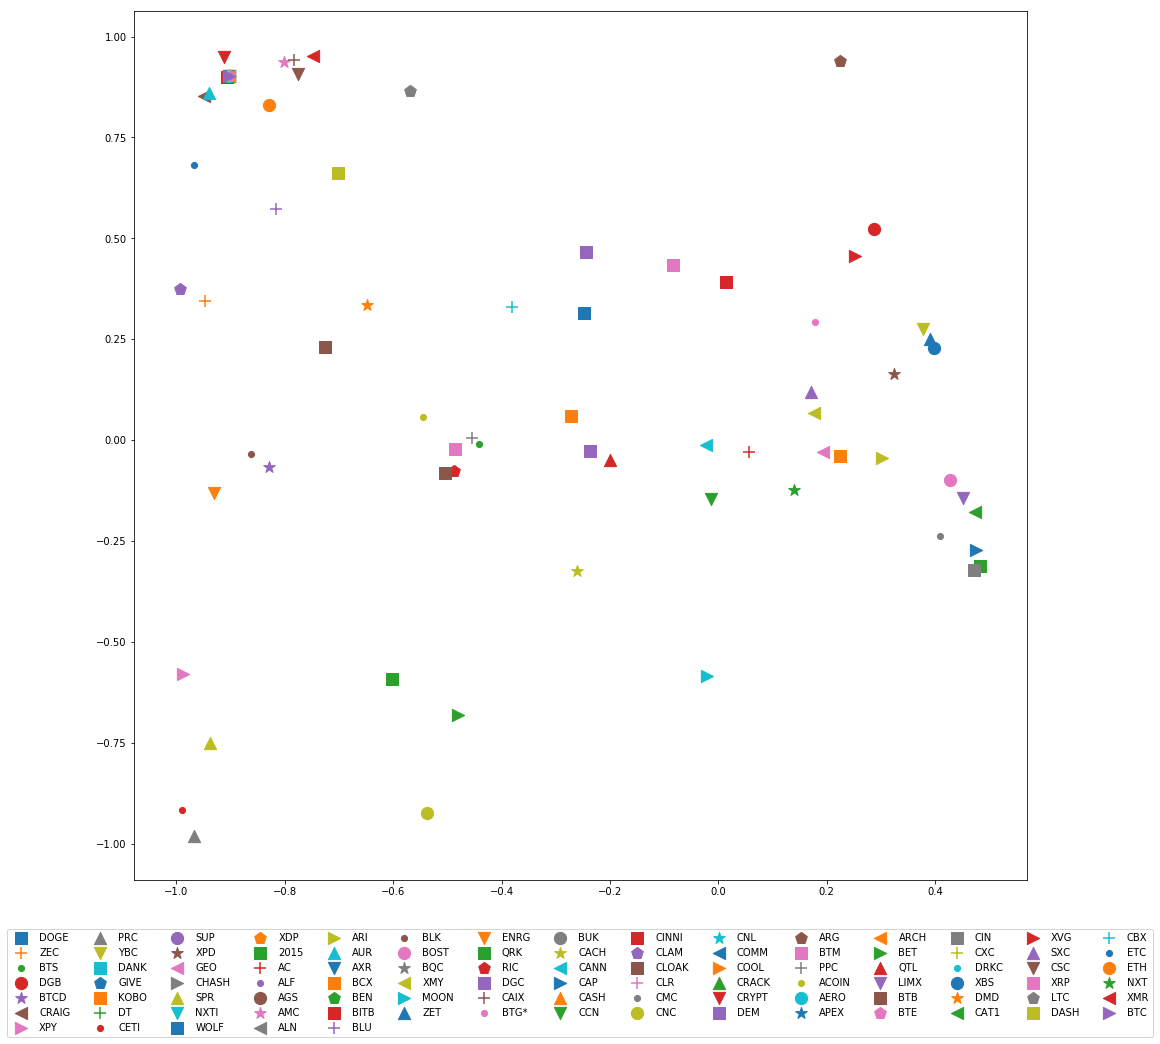

In [47]:
import itertools

# Preparar parametros para el gráfico
colors = np.arange(len(crypto_labels))
labels= crypto_labels
marker = itertools.cycle((',', '+', '.', 'o', '*','<','>','^','v','s','p')) 


# Dibujar Scatter plot 

plt.figure(figsize=(16, 16))
for i in range(len(series_2d)):
    x=series_2d[i][0]
    y=series_2d[i][1]
    plt.scatter(x,y,label=labels[i],marker=next(marker),s=150)
       
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=False, ncol=15)
plt.show()

Una manera de entender lo aprendido por el autoencoder es visualizar series originales de las monedas que se encuentran cercanas en la representación compacta. Visualizando las series cercanas es posible hacerse una idea de lo que representa ese punto del espacio gracias a las características comunes de ese grupo de series.

Por otro lado, explorar distintos grupos a lo largo del espacio permite comprender mejor la implicación de las dimensiones aprendidas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación y análisis:</strong> Seleccionar 3 grupos de puntos distintos a lo largo del espacio y visualizar sus series. Analizar los grupos y sus diferencias para tratar de dar una interpretación a cada una de las dimensiones.
</div>

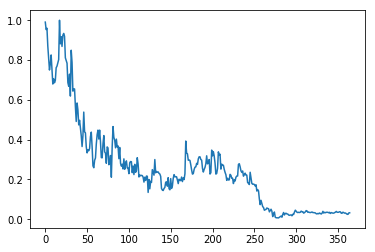

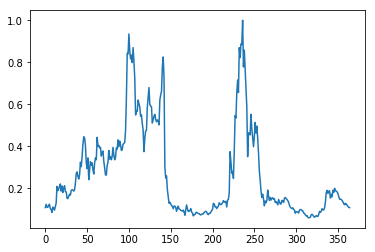

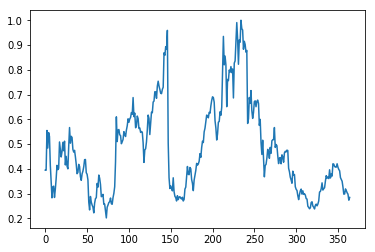

In [50]:
# puntos con valores bajos en dimensión 0 
plt.plot(series_norm.get('PRC'))
plt.show()
plt.plot(series_norm.get('SPR'))
plt.show()
plt.plot(series_norm.get('CLAM'))
plt.show()

No se aprecia un patrón claro en las series que representan a puntos con valores bajos en la dimensión 0.

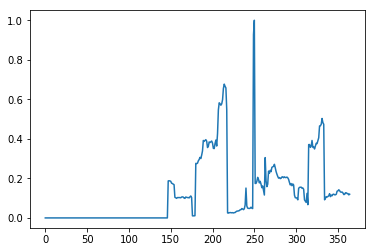

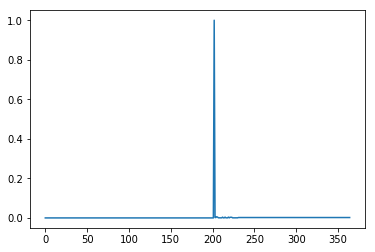

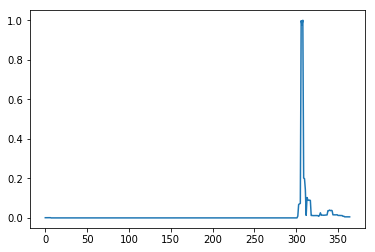

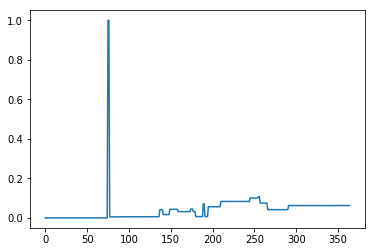

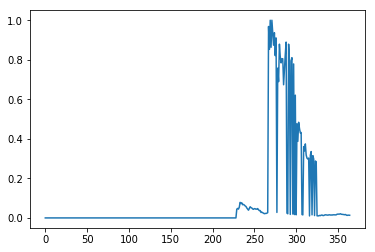

In [49]:
# puntos con valor alto en d0
plt.plot(series_norm.get('YBC'))
plt.show()
plt.plot(series_norm.get('CIN'))
plt.show()
plt.plot(series_norm.get('CAP'))
plt.show()
plt.plot(series_norm.get('BOST'))
plt.show()
plt.plot(series_norm.get('CAT1'))
plt.show()

Observando las series que corresponden a valores altos en la dimensión 0 , se puede observar que son series con picos pronunciados.

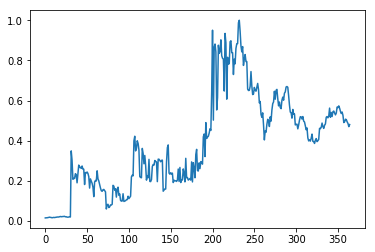

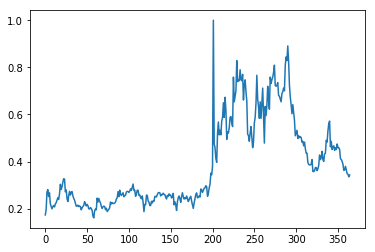

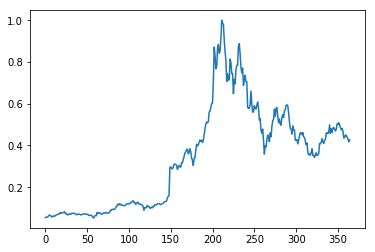

In [52]:
# Puntos con valor alto en d1
plt.plot(series_norm.get('CRYPT'))
plt.show()
plt.plot(series_norm.get('AUR'))
plt.show()
plt.plot(series_norm.get('AMC'))
plt.show()

Las series que corresponden a valores altos en la d1, tienen una tendencia creciente durante la mayoría del año.

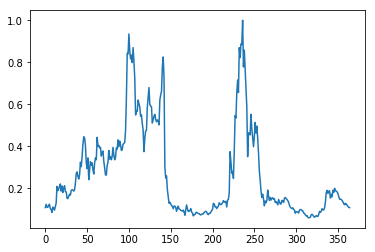

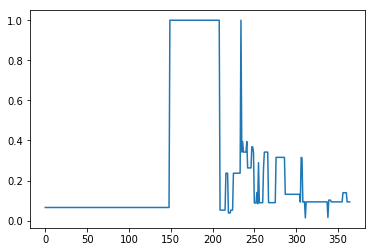

In [54]:
# Puntos con valor bajo en la d1
plt.plot(series_norm.get('SPR'))
plt.show()
plt.plot(series_norm.get('XPY'))
plt.show()

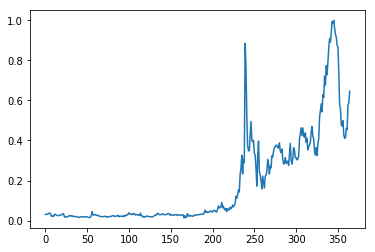

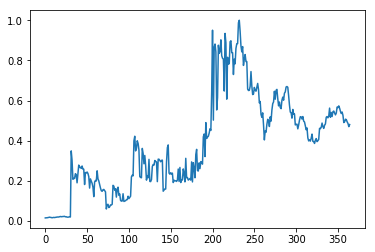

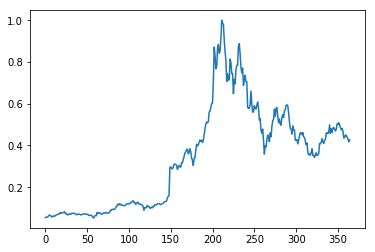

In [57]:
# Puntos alejados en la d0 y muy próximos en la d1
plt.plot(series_norm.get('ARG'))
plt.show()
plt.plot(series_norm.get('CRYPT'))
plt.show()
plt.plot(series_norm.get('AMC'))
plt.show()

Las series que representan a puntos con valores alejados en d0 y próximos en d1 muestran tendencias crecientes.

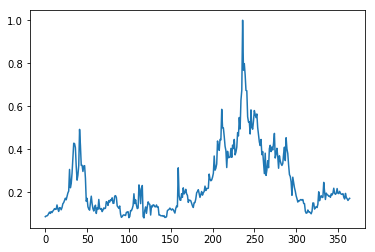

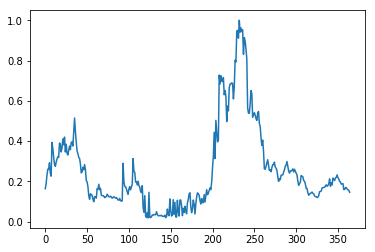

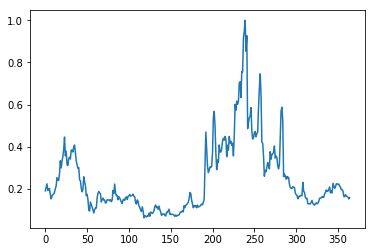

In [58]:
# Series que corresponden a 3 puntos muy cercanos (d0=d1)
plt.plot(series_norm.get('BTB'))
plt.show()
plt.plot(series_norm.get('BTM'))
plt.show()
plt.plot(series_norm.get('RIC'))
plt.show()

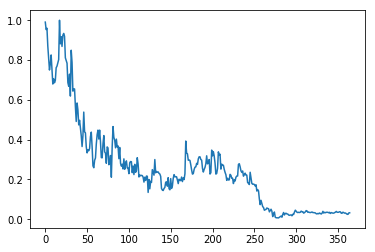

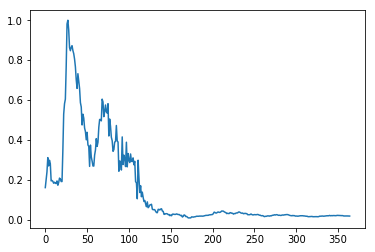

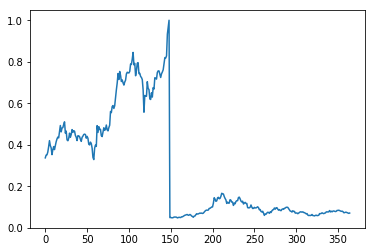

In [62]:
# Puntos con valores muy bajos en d1, se aprecia que tienen tendencia decreciente. 
plt.plot(series_norm.get('PRC'))
plt.show()
plt.plot(series_norm.get('CNC'))
plt.show()
plt.plot(series_norm.get('CETI'))
plt.show()

Podriamos concluir que la d0 está modelando los picos en las series, y la d1 la tendencia.